## Kaggle Toxic comment 

### Project description
Apply Fastai lesson 10 to Kaggle toxic comment challenge. 
The competition has 6 classes, but first will make it binary, i.e. toxic & not toxic.

The overall strategy is to first train a language model. Fortunately, Jeremy H has done the hard work of training a language model on wikipedia (WikiText103). Using the pretrained language model as the backbone, we'll train a classifier to categorize the comments. 

### Load Libraries

In [1]:
from fastai.text import *
import html
import pdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Path  Directories

In [2]:
PATH = Path('/home/odenigborig/Data/kaggle/toxic_comment')

In [3]:
#path to store fine-tuned language model weights. 
LM_PATH = PATH/'LM'
LM_PATH.mkdir(exist_ok=True)

In [4]:
#path to store weights of classifier.
CLASSIFIER_PATH = PATH/'classifier'
CLASSIFIER_PATH.mkdir(exist_ok=True)

### Data Inspection

In [5]:
df = pd.read_csv(PATH/'train.csv')
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [6]:
print('Training set size: {} comments'.format(len(df)))

Training set size: 159571 comments


In [7]:
df[df['toxic'] == 1].tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0
159554,ffbdbb0483ed0841,and i'm going to keep posting the stuff u dele...,1,0,1,0,1,0


In [8]:
CLASSES = list(df.columns.values)[2:]
CLASSES

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Create additional column for binary class.

In [9]:
df['not_toxic'] = df[CLASSES].eq(0).all(1).astype('int')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [10]:
print('# non-toxic comments: {}'.format(sum(df['not_toxic'])))
print('# toxic comments: {}'.format(abs(len(df) - sum(df['not_toxic']))))
print('% not toxic: {:0.2f}%'.format(100*sum(df['not_toxic'])/len(df)))

# non-toxic comments: 143346
# toxic comments: 16225
% not toxic: 89.83%


Notice, there are a lot more non-toxic comments

In [11]:
df['not_toxic'].unique()

array([1, 0])

In [12]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
not_toxic         int64
dtype: object

In [13]:
all_labels = df.drop(['comment_text'],axis=1)
all_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,0000997932d777bf,0,0,0,0,0,0,1
1,000103f0d9cfb60f,0,0,0,0,0,0,1
2,000113f07ec002fd,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,0,0,0,0,0,0,1
4,0001d958c54c6e35,0,0,0,0,0,0,1


In [14]:
binary_label = df.drop(CLASSES+['comment_text'],axis=1)
binary_label.head()

,id,not_toxic
0,0000997932d777bf,1
1,000103f0d9cfb60f,1
2,000113f07ec002fd,1
3,0001b41b1c6bb37e,1
4,0001d958c54c6e35,1


In [16]:
df_texts = df.drop(CLASSES+['not_toxic'],axis=1)
df_texts.head()

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [17]:
df_data = df[['not_toxic','comment_text']]
df_data.head()

,not_toxic,comment_text
0,1,Explanation\nWhy the edits made under my usern...
1,1,D'aww! He matches this background colour I'm s...
2,1,"Hey man, I'm really not trying to edit war. It..."
3,1,"""\nMore\nI can't make any real suggestions on ..."
4,1,"You, sir, are my hero. Any chance you remember..."


In [30]:
(PATH/'tmp').mkdir(exist_ok=True)
df_data.to_csv(PATH/'tmp'/'df_data_binary.csv', header = ['not_toxic','comment_text'],index_label=False )

In [18]:
text_length = df_texts.comment_text.str.len()
text_length.mean(),text_length.std(),text_length.max()

(394.0732213246768, 590.7202819048919, 5000)

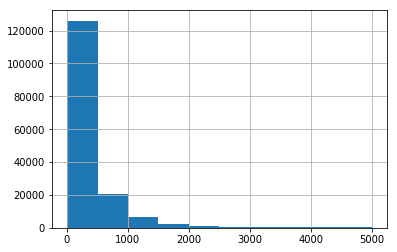

In [19]:
text_length.hist()

## Prepare data for language model

In [11]:
df_testset = pd.read_csv(PATH/'test.csv')
df_testset.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [13]:
texts_test = df_testset['comment_text'].values.tolist()
len(texts_test)

153164

In [15]:
texts = df_texts['comment_text'].values.tolist()
type(texts)
len(texts)

159571

In [16]:
texts[2334]

'"\n\n Emil Gilels \n\nI appreciate your input as to your musical taste regarding Gilel\'s stature as one of the greatest pianists of the 20 th century.  While you may regard this as ""over enthusiastic,"" my addition was supported by one of the pages used as a reference in the article.  If you really have an objection, you are better advised to express your reservations in the discussion page.  I would revert your edits until you act in a civil manner."'

In [17]:
texts_all = texts + texts_test
len(texts_all)

312735

train, valid split for language model training


In [18]:
inds = np.random.rand(len(texts_all)) > 0.1
train_texts = np.asarray(texts_all)[inds]
valid_texts = np.asarray(texts_all)[~inds]
len(train_texts),len(valid_texts)

(281403, 31332)

create csv file containing text for fine-tuning pre-trained language model, save in language model (LM) directory

In [19]:
col_names = ['labels','text']
df_train = pd.DataFrame({'text':train_texts, 'labels':[0]*len(train_texts)},columns=col_names)
df_valid = pd.DataFrame({'text':valid_texts, 'labels':[0]*len(valid_texts)},columns=col_names)

df_train.to_csv(LM_PATH/'train.csv',header=False,index=False)
df_valid.to_csv(LM_PATH/'valid.csv',header=False,index=False)

In [71]:
#!ls /home/odenigborig/Data/kaggle/toxic_comment/LM

.  ..  tmp.csv	train.csv  valid.csv


### Generate Language model tokens

In [26]:
df_train = pd.read_csv(LM_PATH/'train.csv',header=None)
df_valid = pd.read_csv(LM_PATH/'valid.csv',header=None)

In [27]:
df_train.head()

,0,1
0,0,Explanation\nWhy the edits made under my usern...
1,0,"Hey man, I'm really not trying to edit war. It..."
2,0,"You, sir, are my hero. Any chance you remember..."
3,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
4,0,Your vandalism to the Matt Shirvington article...


In [28]:
df_valid.head()

,0,1
0,0,D'aww! He matches this background colour I'm s...
1,0,"""\nMore\nI can't make any real suggestions on ..."
2,0,"""\n\nCongratulations from me as well, use the ..."
3,0,Hey... what is it..\n@ | talk .\nWhat is it......
4,0,"""\n\nJuelz Santanas Age\n\nIn 2002, Juelz Sant..."


fixup is a utility function from fastai for cleaning up text data. 

In [47]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


In [48]:
BOS = 'xbos'  #add beginning of sentence tag
FLD = 'xfld'  #add data field tag

def get_texts_tokens(df,n_labels=1):
    labels = df.iloc[:,range(n_labels)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_labels].astype(str)
    for i in range(n_labels+1,len(df.columns)):
        texts += f' {FLD} {i-n_labels}' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    #create tokens, using multi-processing
    tokens = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens,list(labels)

In [49]:
def get_all(df,n_labels):
    tokens,labels = [],[]
    tokens_,labels_ = get_texts_tokens(df,n_labels)
    tokens += tokens_
    labels += labels_
    return tokens,labels

### Create tokens

In [29]:
valid_tokens,valid_labels = get_all(df_valid,1)

In [30]:
train_tokens,train_labels = get_all(df_train,1)

In [31]:
valid_tokens[4]

['\n',
 'xbos',
 'xfld',
 '1',
 '"',
 '\n\n',
 'juelz',
 'santanas',
 'age',
 '\n\n',
 'in',
 '2002',
 ',',
 'juelz',
 'santana',
 'was',
 '18',
 'years',
 'old',
 ',',
 'then',
 'came',
 'february',
 '18th',
 ',',
 'which',
 'makes',
 'juelz',
 'turn',
 '19',
 'making',
 'songs',
 'with',
 'the',
 'diplomats',
 '.',
 'the',
 'third',
 'neff',
 'to',
 'be',
 'signed',
 'to',
 'cam',
 "'s",
 'label',
 'under',
 'roc',
 'a',
 'fella',
 '.',
 'in',
 '2003',
 ',',
 'he',
 'was',
 '20',
 'years',
 'old',
 'coming',
 'out',
 'with',
 'his',
 'own',
 'singles',
 '"',
 '"',
 'santana',
 "'s",
 'town',
 '"',
 '"',
 'and',
 '"',
 '"',
 'down',
 '"',
 '"',
 '.',
 'so',
 'yes',
 ',',
 'he',
 'is',
 'born',
 'in',
 '1983',
 '.',
 'he',
 'really',
 'is',
 ',',
 'how',
 'could',
 'he',
 'be',
 'older',
 'then',
 'lloyd',
 'banks',
 '?',
 'and',
 'how',
 'could',
 'he',
 'be',
 '22',
 'when',
 'his',
 'birthday',
 'passed',
 '?',
 'the',
 'homie',
 'neff',
 'is',
 '23',
 'years',
 'old',
 '.',
 '1983'

In [32]:
train_tokens[1]

['\n',
 'xbos',
 'xfld',
 '1',
 'hey',
 'man',
 ',',
 'i',
 "'m",
 'really',
 'not',
 'trying',
 'to',
 'edit',
 'war',
 '.',
 'it',
 "'s",
 'just',
 'that',
 'this',
 'guy',
 'is',
 'constantly',
 'removing',
 'relevant',
 'information',
 'and',
 'talking',
 'to',
 'me',
 'through',
 'edits',
 'instead',
 'of',
 'my',
 'talk',
 'page',
 '.',
 'he',
 'seems',
 'to',
 'care',
 'more',
 'about',
 'the',
 'formatting',
 'than',
 'the',
 'actual',
 'info',
 '.']

In [33]:
df_train[1][1]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [75]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [34]:
np.save(LM_PATH/'tmp'/'train_tokens.npy',train_tokens)
np.save(LM_PATH/'tmp'/'valid_tokens.npy',valid_tokens)

In [78]:
#del train_tokens,valid_tokens

In [20]:
train_tokens = np.load(LM_PATH/'tmp'/'train_tokens.npy')
valid_tokens = np.load(LM_PATH/'tmp'/'valid_tokens.npy')

In [35]:
max_vocab = 60000  #max words in vocabulary
min_freq = 2  #minimum frequency of occurence 

In [36]:
freq = Counter(p for o in train_tokens for p in o)
freq.most_common(25) #25 most common words

[('.', 864542),
 ('the', 826190),
 (',', 783314),
 ('"', 667918),
 ('to', 485005),
 ('t_up', 403375),
 ('i', 388099),
 ('of', 369384),
 ('and', 367277),
 ('a', 366562),
 ('\n', 358841),
 ('you', 351511),
 ('is', 308247),
 ('1', 289995),
 ('xbos', 281403),
 ('xfld', 281403),
 ('that', 267241),
 ('it', 249422),
 ('in', 241644),
 (':', 217794),
 ('=', 178517),
 ('for', 166892),
 ('this', 162590),
 ('not', 156593),
 ('-', 156559)]

In [47]:
#create list of words with frequency that exceed min_freq
int_to_str = [o for o,c in freq.most_common(max_vocab) if c > min_freq]

In [50]:
int_to_str.insert(0,'_pad_')
int_to_str.insert(0,'_unk')

In [52]:
int_to_str[1:20]

['_pad_',
 '.',
 'the',
 ',',
 '"',
 'to',
 't_up',
 'i',
 'of',
 'and',
 'a',
 '\n',
 'you',
 'is',
 '1',
 'xbos',
 'xfld',
 'that',
 'it']

In [51]:
len(int_to_str)

60002

Initialize dictionary, str_to_int, such that each frequent word is assigned an index

In [53]:
str_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})
len(int_to_str)

60002

convert tokens to numerical value. use look up table (str_to_int)

In [54]:
train_lm = np.array([[str_to_int[o] for o in p] for p in train_tokens])
valid_lm = np.array([[str_to_int[o] for o in p] for p in valid_tokens])

In [55]:
train_lm[0]

[12,
 16,
 17,
 15,
 736,
 12,
 104,
 3,
 170,
 162,
 208,
 53,
 720,
 4440,
 9431,
 1320,
 111,
 387,
 37,
 66,
 111,
 43,
 13765,
 4,
 74,
 6697,
 27,
 83,
 2536,
 180,
 8,
 2782,
 56,
 143,
 1217,
 15569,
 7,
 2504,
 2,
 10,
 76,
 39,
 43,
 285,
 3,
 391,
 54,
 3,
 75,
 52,
 173,
 8,
 100,
 3733,
 0]

In [56]:
np.save(LM_PATH/'tmp'/'train_ids.npy',train_lm)
np.save(LM_PATH/'tmp'/'valid_ids.npy',valid_lm)
pickle.dump(int_to_str,open(LM_PATH/'tmp'/'int_to_str.pkl','wb'))

In [36]:
train_lm = np.load(LM_PATH/'tmp'/'train_ids.npy')
valid_lm = np.load(LM_PATH/'tmp'/'valid_ids.npy')
int_to_str = pickle.load(open(LM_PATH/'tmp'/'int_to_str.pkl','rb'))

In [57]:
len(int_to_str),len(train_lm)

(60002, 281403)

In [58]:
vs = len(int_to_str)

### wikitext103 conversion
Above we converted the comment texts into integers. Now we are going to use a pretrained model (trained on wikipedia) which may not have the same overlapping integers of words as the imdb dataset, therefore we need to convert/map the comment text/integers to those used in the pretrained model. 

In [59]:
PRE_TRAINED_LM = Path('/home/odenigborig/Github/fastai/courses/dl2/models/wt103')
FWD_PRE_TRAINED_LM = PRE_TRAINED_LM/'fwd_wt103.h5' #forward language model 

In [60]:
weights = torch.load(FWD_PRE_TRAINED_LM, map_location = lambda storage, loc: storage)

In [90]:
weights.keys()

odict_keys(['0.encoder.weight', '0.encoder_with_dropout.embed.weight', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.0.module.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.1.module.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '0.rnns.2.module.weight_hh_l0_raw', '1.decoder.weight'])


In [61]:
weights['0.encoder.weight'].shape

torch.Size([238462, 400])

In [62]:
embed_dim = 400 #embedding dimensions to encode each token
n_units = 1150  #number of hidden units per LSTM layer
n_layers = 3    #number of LSTM layers

In [63]:
encoder_weights = to_np(weights['0.encoder.weight'])
row_mean = encoder_weights.mean(0)

In [64]:
row_mean.shape,encoder_weights.shape

((400,), (238462, 400))

In [65]:
#load int_to_str data used in training wikitext103
int_to_str2 = pickle.load((PRE_TRAINED_LM/'itos_wt103.pkl').open('rb'))
str_to_int2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(int_to_str2)})

match the strings from the kaggle dataset to corresponding string/index of the pretrained wikitext103 language model. this ensures the weights from the pretrained model are correctly assigned/copied over. if the text from the kaggle dataset is not present in the wikitext pretrained model, then assign the average weights across all world from the wikitext model.

In [66]:
new_weights = np.zeros((vs,embed_dim),dtype=np.float32)
for i,val in enumerate(int_to_str):
    r = str_to_int2[val]   #find index of corresponding text in str_to_int2 (i.e. wikitext pretrained model)
    new_weights[i] = encoder_weights[r] if r >= 0 else row_mean #if the text does not exist, assign the mean

In [67]:
new_weights.shape

(60002, 400)

In [68]:
weights['0.encoder_with_dropout.embed.weight'].shape,weights['1.decoder.weight'].shape

(torch.Size([238462, 400]), torch.Size([238462, 400]))

Overwrite the weights stores in the dictionary. The decoder module will also share the same weights. This idea is called weight tying.

In [69]:
weights['0.encoder.weight'] = T(new_weights)  #convert to tensor
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

In [70]:
weights['0.encoder.weight'].shape,weights['0.encoder_with_dropout.embed.weight'].shape, weights['1.decoder.weight'].shape

(torch.Size([60002, 400]), torch.Size([60002, 400]), torch.Size([60002, 400]))

## Fine-tune language model
with texts comments 

In [71]:
weight_decay = 1e-7  #weight decay
bptt = 70 #backpropagation thru time
bs = 32   #batch size
optim_fn = partial(optim.Adam, betas=(0.8,0.99))

In [72]:
train_dataloadr = LanguageModelLoader(np.concatenate(train_lm),bs,bptt)
valid_dataloadr = LanguageModelLoader(np.concatenate(valid_lm),bs,bptt)
model = LanguageModelData(PATH,pad_idx=1,n_tok=vs,trn_dl=train_dataloadr,val_dl=valid_dataloadr,bs=bs,bptt=bptt)

In [73]:
dropouts = np.array([0.25,0.1,0.2,0.02,0.15])*0.7
dropouts

array([0.175, 0.07 , 0.14 , 0.014, 0.105])

In [74]:
learner = model.get_model(optim_fn,embed_dim,n_units,n_layers,
                          dropouti=dropouts[0],dropout=dropouts[1],
                          wdrop=dropouts[2],dropoute=dropouts[3],
                          dropouth=dropouts[4])
learner.metrics = [accuracy]
learner.unfreeze()

In [75]:
learner.model.load_state_dict(weights)

In [76]:
lr = 1e-3
lrs = lr

In [77]:
learner.fit(lrs/2,1,wds=weight_decay,use_clr=(32,2),cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      4.018563   3.76266    0.359482  



[array([3.76266]), 0.3594822928909128]

The accuracy reports how well the language model predicts the target word correctly. It's useful to check for the language model, but it's not factored into the loss function as it is quire bumpy. Instead, minimize the cross-entropy loss. 

the exponent of the cross-entropy loss is called the perplexity of the LM (lower perplexity is better)

In [78]:
learner.save('LM_last_finetune')
#learner.load('LM_last_finetune')

In [79]:
learner.unfreeze()

In [80]:
learner.lr_find(start_lr=lrs/10,end_lr=lrs*10,linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.514437   4.309142   0.309737  



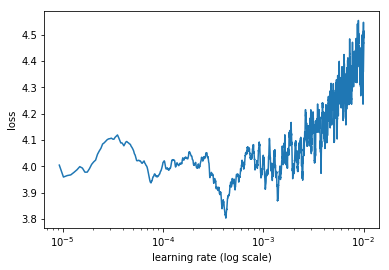

In [81]:
learner.sched.plot()

In [82]:
learner.fit(lrs,1,wds=weight_decay,use_clr=(20,10),cycle_len=15)

epoch      trn_loss   val_loss   accuracy                       
    0      3.963872   3.743951   0.362484  
    1      3.886291   3.714686   0.366242                       
    2      3.844792   3.681869   0.371386                       
    3      3.816806   3.656637   0.374708                       
    4      3.787066   3.637713   0.37698                        
    5      3.7537     3.622993   0.379264                       
    6      3.739078   3.614812   0.380887                       
    7      3.762692   3.602606   0.381816                       
    8      3.733348   3.591303   0.383129                       
    9      3.702831   3.586871   0.384253                       
    10     3.669114   3.582836   0.385003                       
    11     3.647921   3.573874   0.386374                       
    12     3.633496   3.568526   0.387269                       
    13     3.640911   3.562581   0.388075                       
    14     3.601844   3.558244   0.388717     

[array([3.55824]), 0.3887172775010701]

In [83]:
learner.save('LM1')
learner.save_encoder('LM1_encoder')
learner.save('LM1_last')

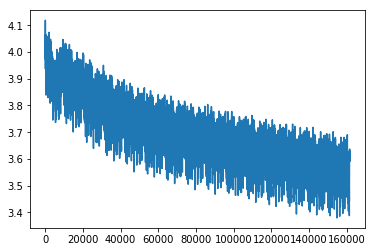

In [84]:
learner.sched.plot_loss()

In [107]:
#learner.load('LM1')

## Text Classification on toxic comments

### Prepare data

In [42]:
df_data = pd.read_csv(PATH/'tmp'/'df_data_binary.csv')

df_train_class,df_rest_class = train_test_split(df_data,test_size=0.2)
df_valid_class,df_test_class = train_test_split(df_data,test_size=0.075)

In [43]:
display(df_train_class.head()),display(df_valid_class.head())

,not_toxic,comment_text
145445,1,Ch ch ch ch changes\nI'm converting this list ...
25211,1,"""__TOC__\n\n Hello ! Welcome to Wikipedia! Th..."
10468,1,""", 19 March 2007 (UTC)\n\nIf I really had my w..."
96957,1,"""\n\nProbably not in the infobox. If it's rel..."
68067,1,P.S. - I was the one who created the music art...


,not_toxic,comment_text
22442,1,What about the arcade game? \n\nI saw a crimso...
74580,1,"Wikisource\nIf you regret it so much, why did ..."
11270,1,"""\n The information was quite correct, and man..."
84020,1,This article is still locked i wanted to chang...
27709,1,"Fair enough, but referring to it as offensive ..."


(None, None)

In [44]:
len(df_train_class),len(df_valid_class),len(df_test_class)

(127656, 147603, 11968)

In [45]:
sum(df_train_class['not_toxic'])/len(df_train_class),sum(df_valid_class['not_toxic'])/len(df_valid_class),sum(df_test_class['not_toxic'])/len(df_test_class)

(0.8975606316976875, 0.8980373027648489, 0.9018215240641712)

In [46]:
#re-label columns as 0 & 1 for use in get_all function
col_names = [0,1] 

df_train_class.index = np.arange(len(df_train_class))
df_train_class.columns = col_names
df_valid_class.index = np.arange(len(df_valid_class))
df_valid_class.columns = col_names
df_test_class.index = np.arange(len(df_test_class))
df_test_class.columns = col_names

df_train_class.head()

,0,1
0,1,Ch ch ch ch changes\nI'm converting this list ...
1,1,"""__TOC__\n\n Hello ! Welcome to Wikipedia! Th..."
2,1,""", 19 March 2007 (UTC)\n\nIf I really had my w..."
3,1,"""\n\nProbably not in the infobox. If it's rel..."
4,1,P.S. - I was the one who created the music art...


In [50]:
train_tokens,train_labels = get_all(df_train_class,1)
valid_tokens,valid_labels = get_all(df_valid_class,1)
test_tokens,test_labels = get_all(df_test_class,1)

In [51]:
valid_tokens[10]

['\n',
 'xbos',
 'xfld',
 '1',
 'no',
 ',',
 'it',
 "'s",
 'not',
 'a',
 'delayed',
 'reaction',
 '\n\n',
 'i',
 'just',
 'happened',
 'to',
 'read',
 'your',
 'wonderful',
 'warning',
 'yesterday',
 '.',
 'unlike',
 'you',
 ',',
 'i',
 'do',
 "n't",
 'visit',
 'wikipedia',
 'everyday',
 '.',
 'but',
 'i',
 "'m",
 'surprised',
 'to',
 'see',
 'that',
 'you',
 'are',
 'too',
 'dense',
 'to',
 'figure',
 'that',
 'out',
 '.',
 '\n\n',
 'idiot',
 '.',
 'tk_wrep',
 '5',
 'ha',
 'xd']

In [52]:
#save tokens and labels
(CLASSIFIER_PATH/'tmp').mkdir(exist_ok=True)
np.save(CLASSIFIER_PATH/'tmp'/'train_tokens.npy',train_tokens)
np.save(CLASSIFIER_PATH/'tmp'/'valid_tokens.npy',valid_tokens)
np.save(CLASSIFIER_PATH/'tmp'/'test_tokens.npy',test_tokens)

np.save(CLASSIFIER_PATH/'tmp'/'train_labels.npy',train_labels)
np.save(CLASSIFIER_PATH/'tmp'/'valid_labels.npy',valid_labels)
np.save(CLASSIFIER_PATH/'tmp'/'test_labels.npy',test_labels)


In [5]:
train_tokens = np.load(CLASSIFIER_PATH/'tmp'/'train_tokens.npy')
valid_tokens = np.load(CLASSIFIER_PATH/'tmp'/'valid_tokens.npy')
test_tokens = np.load(CLASSIFIER_PATH/'tmp'/'test_tokens.npy')

In [53]:
int_to_str = pickle.load((LM_PATH/'tmp'/'int_to_str.pkl').open('rb'))
str_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})
len(int_to_str)

60002

Map the token ids used in the language model to the tokens created from the toxic comments data

In [54]:
train_class_inds = np.array([[str_to_int[o] for o in p] for p in train_tokens])
valid_class_inds = np.array([[str_to_int[o] for o in p] for p in valid_tokens])
test_class_inds = np.array([[str_to_int[o] for o in p] for p in test_tokens])

In [55]:
#save data
np.save(CLASSIFIER_PATH/'tmp'/'train_ids.npy',train_class_inds)
np.save(CLASSIFIER_PATH/'tmp'/'valid_ids.npy',valid_class_inds)
np.save(CLASSIFIER_PATH/'tmp'/'test_ids.npy',test_class_inds)

In [6]:
train_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'train_ids.npy')
valid_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'valid_ids.npy')
test_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'test_ids.npy')

#reverse the sign of the labels, such that toxic = 1 and not_toxic = 0
train_labels = 1 - np.squeeze(np.load(CLASSIFIER_PATH/'tmp'/'train_labels.npy'))
valid_labels = 1 - np.squeeze(np.load(CLASSIFIER_PATH/'tmp'/'valid_labels.npy'))
test_labels = 1 - np.squeeze(np.load(CLASSIFIER_PATH/'tmp'/'test_labels.npy'))

int_to_str = pickle.load((LM_PATH/'tmp'/'int_to_str.pkl').open('rb'))
str_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})


### Create model dataloader. 

First we will need to pad the sequences to the same length in each batch. To create batches of the same size, we use the SortishSampler. The SortishSampler cuts down the overall number of padding tokens fed into the classifier.

In [9]:
bs = 16           #batch size

train_dataset = TextDataset(train_class_inds,train_labels) 
valid_dataset = TextDataset(valid_class_inds,valid_labels)
test_dataset = TextDataset(test_class_inds,test_labels)

train_sampler = SortishSampler(train_class_inds,key=lambda x: len(train_class_inds),bs=bs//2)
valid_sampler = SortSampler(valid_class_inds,key=lambda x: len(valid_class_inds[x]))
test_sampler = SortSampler(test_class_inds,key=lambda x: len(test_class_inds[x]))

train_dataloader = DataLoader(train_dataset,bs//2,transpose=True,num_workers=1,pad_idx=1,sampler=train_sampler)
valid_dataloader = DataLoader(valid_dataset,bs,transpose=True,num_workers=1,pad_idx=1,sampler=valid_sampler)
test_dataloader = DataLoader(test_dataset,bs,transpose=True,num_workers=1,pad_idx=1,sampler=test_sampler)

model = ModelData(PATH,train_dataloader,valid_dataloader,test_dataloader)

### Create RNN Classifier
As mentioned above, our classifier consists of 3 LSTM (AWD-LSTM) layers followed by 2 linear layers (including the classification layer).

In [10]:
embed_dim = 400   #embedding dimensions to encode each token
n_units = 1150    #number of hidden activation units per LSTM layer
n_layers = 3      #number of LSTM layers
vocab_size = len(int_to_str) #number of tokens/vocabulary size
bptt = 70         #batch size for back prop thru time  
dropouts = np.array([0.4,0.5,0.05,0.3,0.4])*0.5 #dropout for each layer of the model

In [11]:
n_cats = int(train_labels.max()) + 1 #number of categories or classes
n_cats

2

Create RNN classifier object. 

In [11]:
m = get_rnn_classifer(bptt,max_seq=20*70,n_class=n_cats,n_tok=vocab_size,emb_sz=embed_dim,n_hid=n_units,
                      n_layers=n_layers,pad_token=1,layers=[embed_dim*3,5,n_cats],
                      drops=[dropouts[4],0.1],dropouti=dropouts[0],wdrop=dropouts[1],
                      dropoute=dropouts[2],dropouth=dropouts[3])

In [17]:
optim_fn = partial(optim.Adam, betas=(0.7,0.99))

In [33]:
torch.cuda.empty_cache()

Create RNN learner object

In [13]:
learn = RNN_Learner(model, TextModel(to_gpu(m)),opt_fn=optim_fn)
learn.reg_fn = partial(seq2seq_reg,alpha=2,beta=1) #regularization function
learn.clip = 25.   #gradient clipping
learn.metrics = [accuracy]

**Discriminative learning rates:** enables different learning rates for each layer of the model

In [13]:
lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [12]:
weight_decay=1e-7

Use the lr_find function to find appropriate learning rate.

In [73]:
learn.lr_find(lrs/1000)

 77%|███████▋  | 12360/15957 [1:02:07<18:04,  3.32it/s, loss=0.699]

if out of memory run: 

**torch.cuda.empty_cache()**


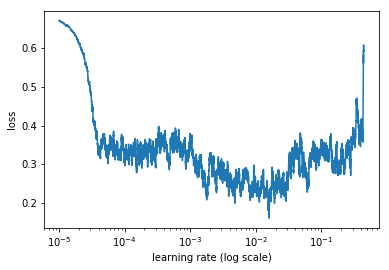

In [74]:
learn.sched.plot()



Freeze all the but the last layer and train the model to predict the labels. currently using cross_entropy loss.

In [75]:
learn.freeze_to(-1)

In [76]:
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.31396    0.299147   0.912899  


[array([0.29915]), 0.9128992750143331]

Already getting 91.3% without the pretrained language model! Better than 91.2% obtained by https://arxiv.org/pdf/1802.09957v1.pdf

there's reason to be skeptical because of the huge class imbalance. 

In [78]:
learn.save('classifier_0') #without pretrained backbone.

Load the pretrained langauge model weights (i.e. backbone) 'LM1_encoder'. Freeze all but the last layer and train. 

In [79]:
learn.load_encoder('LM1_encoder')
learn.freeze_to(-1)

In [80]:
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.193794   0.123699   0.954086  


[array([0.1237]), 0.9540862062840259]

Loss decreased, but accuracy unchanged. 

In [81]:
learn.save('classifier_1')

Freeze all but the last two layers & train

In [82]:
learn.freeze_to(-2)
learn.fit(lrs,1,wds=weight_decay,cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.149369   0.093434   0.964057  


[array([0.09343]), 0.9640565967815439]

In [83]:
learn.save('classifier_2')

Wow! 96.4%

In [32]:
learn.load('classifier_2')

Unfreeze all layers

In [84]:
learn.unfreeze()
learn.fit(lrs,1,wds=weight_decay,cycle_len=4,use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy   
    0      0.081417   0.076252   0.972891  
    1      0.125883   0.069384   0.973956  
    2      0.089851   0.067905   0.975714  
    3      0.098539   0.062587   0.976398  


[array([0.06259]), 0.9763983813390307]

In [ ]:
learn.save('classifier_3')

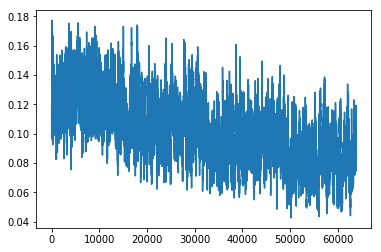

In [ ]:
learn.sched.plot_loss()

In [16]:
learn.summary

<bound method Learner.summary of SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.15)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.15)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.15)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=5, bias=True)
        (drop): Dropout(p=0.2)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=5, out_featu

In [17]:
learn.load('classifier_2')

In [40]:
test_log_pred = learn.predict(is_test=True) #log probabilities
test_preds = np.argmax(test_log_pred,axis=1) #convert to 0 and 1
test_prob = np.exp(test_log_prob)

In [43]:
test_preds[1],test_prob[1]

(0, array([3.6173 , 0.56393], dtype=float32))

In [48]:
y_test = test_labels

array([0, 0, 0, ..., 0, 1, 0])

In [26]:
def plot_confusion_matrix(y_true,y_pred, labels=[1,0],title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true,y_pred,labels=labels)
    conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:,np.newaxis]
    plt.figure()
    LABELS = ['Toxic','Not Toxic']
    sns.heatmap(conf_matrix,xticklabels=LABELS,yticklabels=LABELS,annot=True)
    plt.title(title)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
 

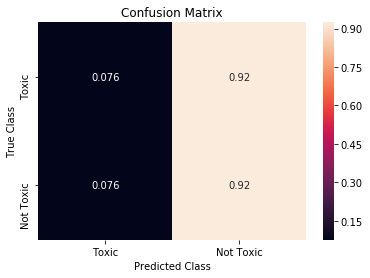

In [59]:
plot_confusion_matrix(y_test, test_preds)

Seems like our classifier performance is actually labeling everything as 'Not toxic' which is the most dominant class in our dataset. 

In [61]:
learn.load('classifier_3')
test_log_pred = learn.predict(is_test=True) #log probabilities
test_preds = np.argmax(test_log_pred,axis=1) #convert to 0 and 1
test_prob = np.exp(test_log_prob)
y_test = test_labels

In [70]:
test_preds[1],test_prob[1]

(1, array([3.6173 , 0.56393], dtype=float32))

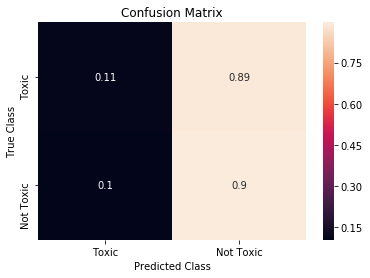

In [63]:
plot_confusion_matrix(y_test, test_preds)

'Classifier_3' performs a little bit better than 'classifier_2' in predicting toxic labels. 

## Handling class imbalance
- Sample weight - will have to write custom function
- cross validation

In [75]:
imbalance = 1 - sum(train_labels)/len(train_labels)
imbalance

0.8975606316976875

In [155]:
def cross_entropy_weighted(inp,target,weight=[0.1,1]):
    weight=to_gpu(Variable(torch.from_numpy(np.array(weight)).float()))
    return F.cross_entropy(inp,target,weight=weight)


In [156]:
cross_entropy_weighted

<function __main__.cross_entropy_weighted(inp, target, weight=[0.1, 1])>

### Weighted loss function

In [157]:
learn = RNN_Learner(model, TextModel(to_gpu(m)),opt_fn=optim_fn)
learn.reg_fn = partial(seq2seq_reg,alpha=2,beta=1) 
learn.clip = 25.
learn.metrics = [accuracy]
learn.crit = cross_entropy_weighted

In [158]:
lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
weight_decay=1e-7

learn.freeze_to(-1)


In [159]:
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))
learn.save('classifier_w_0') #without pretrained backbone.


epoch      trn_loss   val_loss   accuracy                         
    0      0.163472   0.121403   0.959675  



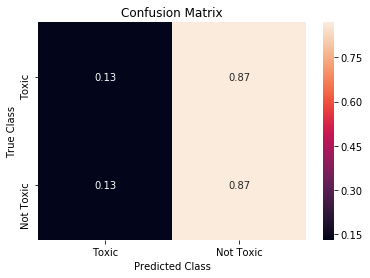

In [160]:
test_log_pred = learn.predict(is_test=True) #log probabilities
test_preds = np.argmax(test_log_pred,axis=1) #convert to 0 and 1

plot_confusion_matrix(y_test,test_preds)

the weighted loss function does not seem to be working... might have better luck with changing the sample size to match. 

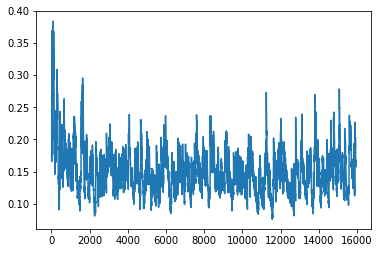

In [162]:
learn.sched.plot_loss()

In [163]:
from sklearn.metrics import classification_report

print(classification_report(y_test,test_preds))

             precision    recall  f1-score   support

          0       0.90      0.87      0.88     10793
          1       0.10      0.13      0.11      1175

avg / total       0.82      0.80      0.81     11968



### Re-sampling.

In [164]:
def oversample_data(X,y,minor_label=1):
    n_samples = len(y)
    
    X_minor, y_minor = X[y==minor_label], y[y==minor_label]
    n_minor = len(y_minor)
    imbal_ratio = np.floor((n_samples - n_minor)/n_minor)

    X_minor_ovs = np.repeat(X_minor,imbal_ratio)
    y_minor_ovs = np.repeat(y_minor,imbal_ratio)

    X_major,y_major = X[y==1-minor_label],y[y==1-minor_label]
    X_ovs = np.concatenate((X_major,X_minor_ovs),axis=0)
    y_ovs = np.concatenate((y_major,y_minor_ovs),axis=0)
    
    inds = np.random.permutation(len(y_ovs))
    X_ovs,y_ovs = X_ovs[inds],y_ovs[inds]

    return X_ovs,y_ovs

In [165]:
train_class_inds_ovs,train_labels_ovs = oversample_data(train_class_inds,train_labels,minor_label=1)
np.save(CLASSIFIER_PATH/'tmp'/'train_ids_ovs.npy',train_class_inds_ovs)
np.save(CLASSIFIER_PATH/'tmp'/'train_labels_ovs.npy',train_labels_ovs)

In [5]:
train_class_inds_ovs = np.load(CLASSIFIER_PATH/'tmp'/'train_ids_ovs.npy')
train_labels_ovs = np.load(CLASSIFIER_PATH/'tmp'/'train_labels_ovs.npy')

In [14]:
train_dataset_ovs = TextDataset(train_class_inds_ovs,train_labels_ovs) 
train_sampler_ovs = SortishSampler(train_class_inds_ovs,key=lambda x: len(train_class_inds_ovs),bs=bs//2)
train_dataloader_ovs = DataLoader(train_dataset_ovs,bs//2,transpose=True,num_workers=1,pad_idx=1,sampler=train_sampler_ovs)

model = ModelData(PATH,train_dataloader_ovs,valid_dataloader,test_dataloader)

In [15]:
dropouts = np.array([0.4,0.5,0.05,0.3,0.4])*0.3 #dropout for each layer of the model
m = get_rnn_classifer(bptt,max_seq=20*70,n_class=n_cats,n_tok=vocab_size,emb_sz=embed_dim,n_hid=n_units,
                      n_layers=n_layers,pad_token=1,layers=[embed_dim*3,5,n_cats],
                      drops=[dropouts[4],0.1],dropouti=dropouts[0],wdrop=dropouts[1],
                      dropoute=dropouts[2],dropouth=dropouts[3])

In [18]:
learn = RNN_Learner(model, TextModel(to_gpu(m)),opt_fn=optim_fn)
learn.reg_fn = partial(seq2seq_reg,alpha=2,beta=1) #regularization function
learn.clip = 25.   #gradient clipping
learn.metrics = [accuracy]

In [171]:
learn.freeze_to(-1)
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))
learn.save('classifier_ovs_0') #without pretrained lm backbone.

epoch      trn_loss   val_loss   accuracy                          
    0      0.671813   0.904842   0.087053  



[array([0.90484]), 0.08705294796469891]

In [19]:
learn.load_encoder('LM1_encoder')
learn.freeze_to(-1)
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                          
    0      0.377612   0.196252   0.934725  



[array([0.19625]), 0.9347250279311815]

In [20]:
learn.save('classifier_ovs_1') #with pretrained lm backbone.

In [21]:
learn.freeze_to(-2)
learn.fit(lrs,1,wds=weight_decay,cycle_len=1, use_clr=(8,3))
learn.save('classifier_ovs_2')

epoch      trn_loss   val_loss   accuracy                          
    0      0.239793   0.202568   0.930844  



In [23]:
learn.unfreeze()
learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(32,10))
learn.save('classifier_ovs_3')

epoch      trn_loss   val_loss   accuracy                             
    0      0.144033   0.071772   0.974924  



[array([0.07177]), 0.9749239549082926]

In [24]:
learn.save('classifier_ovs_3')

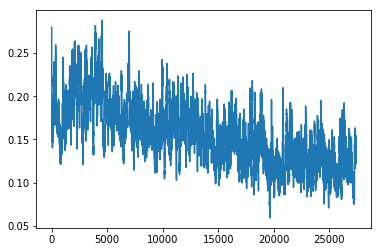

In [25]:
learn.sched.plot_loss()

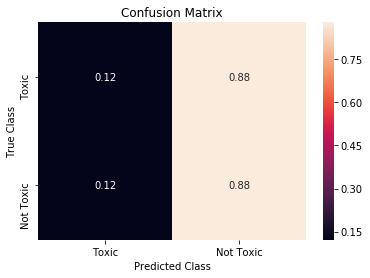

In [30]:
y_test =valid_labels
test_log_pred = learn.predict(is_test=False) #log probabilities
test_preds = np.argmax(test_log_pred,axis=1) #convert to 0 and 1

plot_confusion_matrix(y_test,test_preds)

In [31]:
#from sklearn.metrics import classification_report

print(classification_report(y_test,test_preds))

             precision    recall  f1-score   support

          0       0.90      0.88      0.89    132553
          1       0.10      0.12      0.11     15050

avg / total       0.82      0.80      0.81    147603



### TO-DO : 
- confusion matrix
- handle class imbalance:
    - ~~set 'weight' parameter to handle class imbalance.~~
    - undersampling
    - oversampling
- ~~include bwd model~~
